Refracted gaussian processes code

In [2]:
import numpy as np
import numpy.matlib as matlib
import pandas as pd
import scipy.linalg
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl

SET PLOT PARAMS FOR CONSISTENCY

In [99]:
### plot font size params ###

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
# plt.rc('axes', titlesize=SMALL_SIZE, labelsize = SMALL_SIZE, labelweight = 'bold')     # fontsize of the axes title, x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"


C:\Users\srdal\AppData\Local\Temp\ipykernel_8600\1909273724.py:10: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
C:\Users\srdal\AppData\Local\Temp\ipykernel_8600\1909273724.py:11: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble'] = [r'\boldmath']


Kernel Functions

In [181]:
# Squared exponential covariance function
def Kexp(hyps,x1,x2):
    '''
    Covariance matrix calculation with some vectorisation techniques
    '''
    n1 = x1.shape[0]
    m = x1.shape[1]
    n2 = x2.shape[0]
    
    a = float( hyps[0] )
    d = hyps[1:]

    Ksum = np.zeros( (n1,n2) )

    for i in range(0,m): 

        Kdiff = np.tile( x1[:,i] , (n2,1) ).T - np.tile( x2[:,i] , (n1,1) )
        
        Ksum += float( d[i] ) * np.square(Kdiff) 
    
    K = a * np.exp( -0.5 * Ksum )
    
    return K

# Trace(A*B) function to save computational time
def traceAB(A,B): 
    '''
    Calculates trace of A*B
    '''
    # A and B assumed to be square
    n = A.shape[0]

    trace = float(0)

    for i in range(0,n):
        trace += float( A[i,:] @ B[:,i] ) 
    
    return trace

# diag-add function
def diagAdd(v,A):
    '''
    Adds scalar value to the diagonal of A
    '''
    # n = A.shape[0]
    B = np.copy(A)
    np.fill_diagonal(B, B.diagonal() + v) 
    

    # for i in range(0,n):
        
    #     A[i,i] += v

    return B


# Negative log-likelihood function (constants and scaling removed)
def nLL(log_hyps,x,y):
    '''
    Calculates the negative log likelihood given hyperparameters, inputs x and outputs y
    '''

    hypsK = np.exp ( log_hyps[:-1] )

    v =  np.exp( log_hyps[-1] ) 

    K = Kexp(hypsK,x,x) 

    # Add noise variance and invert
    Q = diagAdd(v,K)
    invQ = la.inv(Q)

    # Numerically stable calculation  of logdet(Q)
    log_det = np.sum( np.log ( la.svd(Q)[1] ) )  

    negLogLike = float( np.transpose(y) @ invQ @ y + log_det )
    
    return negLogLike

# nLL Jacobian function
def DnLL(log_hyps,x,y):
    '''
    Calculates the gradient of the negative log likelihood given hyperparameters, inputs x and outputs y
    '''
    n = x.shape[0]
    m = x.shape[1]

    hypsK = np.exp ( log_hyps[:-1] )
    v = float( np.exp( log_hyps[-1] ) )
    
    K = Kexp(hypsK,x,x) 
    
    # Add noise variance and invert
    Omega = diagAdd( v , np.matlib.zeros( (n,n) ) )
    Q = K + Omega 
    # Q = diagAdd( v , K)
    invQ = la.inv(Q)

    yTinvQ = np.transpose(y) @ invQ

    Jac = np.zeros( (m+2,) )

    DaQ = K
    Jac[0] = traceAB(invQ,DaQ) - yTinvQ @ DaQ @ yTinvQ.transpose()

    for i in range(1,m+1):
        
        Kdiff = np.tile( x[:,i-1] , (n,1) ).T - np.tile( x[:,i-1] , (n,1) )
        d = float( hypsK[i] ) 
        DdQ = np.multiply( np.matrix( -d/2 * np.square(Kdiff) ) , K ) # pointwise multiplication
        Jac[i] = traceAB(invQ,DdQ) - yTinvQ @ DdQ @ yTinvQ.transpose()
    
    DvQ = Omega
    Jac[m+1] = traceAB(invQ,DvQ) - yTinvQ @ DvQ @ yTinvQ.transpose()

    return Jac

# Perform hyperparameter learning
def hypLearn_exp(x,y):
    '''
    Perform MLE to estimate the hyperparameters from data. 
    Uses the scipy.optimize minimise method to minimise the negloglike.
    '''
    n = x.shape[0]
    m = x.shape[1]

    # define initial log_hyperparameter values for optimisation, drawing them from standard normal dist.
    log_hyps0 = np.random.normal(0,1, (m+2,) )      

    res = minimize( nLL , log_hyps0, (x,y), method = 'BFGS', jac = DnLL, options = {'disp': True}  )
    hyps = np.exp( res.x )
    print('Learned hyperparameters [a,d,v] = ', hyps)
    
    return hyps

# GP predictions
def GPpred(hyps,x,y,x_pred):
    '''
    Make predictions on input domain x_pred.
    '''

    Kx = Kexp(hyps[:-1],x,x)
    Q = diagAdd(np.sqrt(hyps[-1]),Kx)
    invQ = la.inv(Q)

    Kpx = Kexp(hyps[:-1],x_pred,x)
    Kpp = Kexp(hyps[:-1],x_pred,x_pred)
    
    pred = Kpx @ invQ @ y # GP prediction on x_pred

    cov = Kpp - Kpx @ invQ @ Kpx.transpose() # GP covariance matrix on x_pred
    std = np.sqrt( np.diag( cov ) ).reshape(-1,1) # GP standard deviations on x_pred

    return pred, std

def calc_rmse(actual,predicted):  
    return np.sqrt(np.square(np.subtract(actual,predicted)).mean() )  

Sample from GP

In [167]:
n = 200
xmin = 1
xmax = 20
x = np.linspace(xmin,xmax,n).reshape(-1,1)

# define hyps
a = 1
d = 1

Kx = Kexp([a,d],x,x)
sqrtKx = np.real( la.sqrtm(Kx) )

y = np.random.normal(0,1, (1,n)) @ sqrtKx # draw from gp

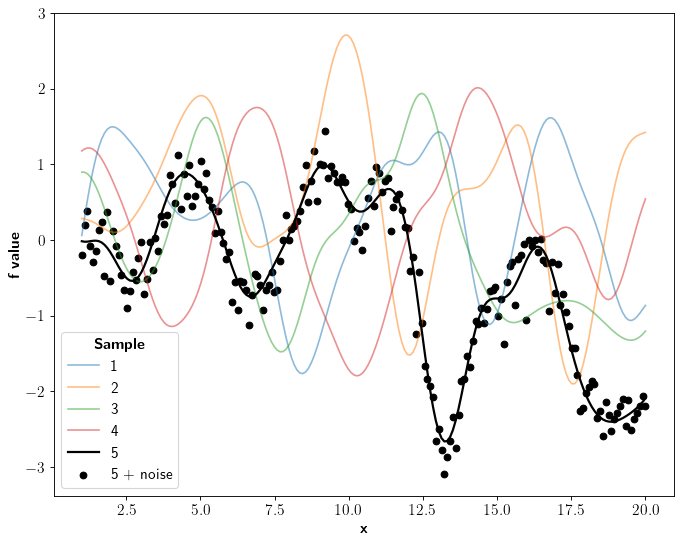

In [176]:
sig = 0.25
plt.figure(figsize=(10,8), dpi = 80)
for i in range(6):
    if i<4:
        y = np.random.normal(0,1, (1,n)) @ sqrtKx # draw from gp
        plt.plot(x,y.reshape(-1,1), label = f'{i+1}', alpha = 0.5)
    elif i == 4:
        y = np.random.normal(0,1, (1,n)) @ sqrtKx # draw from gp
        plt.plot(x,y.reshape(-1,1), label = f'{i+1}', alpha = 1, linewidth= 2, color = 'k')
    else:
        y_noise = y + np.random.normal(0,sig, (1,n) )   # draw from gp with noise
        plt.scatter(x,y_noise.reshape(-1,1), label = f'{i} + noise', alpha = 1, color = 'k')
        
plt.legend(title = r'\textbf{Sample}')
plt.ylabel(r'\textbf{f value}')
plt.xlabel(r'\textbf{x}')
plt.show()

Add measurements and sample from posterior

In [7]:
M = 3
x_meas = 10*np.random.rand(M,1)
y_meas = 10*(np.random.rand(M,1) - 0.5)
print(y_meas)

K_x_meas = Kexp([a,l],x_meas,x_meas)

K_x_joint = Kexp([a,l],x,x_meas)

mu_post = K_x_joint@np.linalg.inv(K_x_meas)@y_meas
K_post = K_x - K_x_joint@np.linalg.inv(K_x_meas)@K_x_joint.T
std_post = np.sqrt(np.diag(K_post))

sqrtK = np.real(scipy.linalg.sqrtm(K_post))

[[ 0.88476649]
 [ 1.38959047]
 [-2.34064289]]


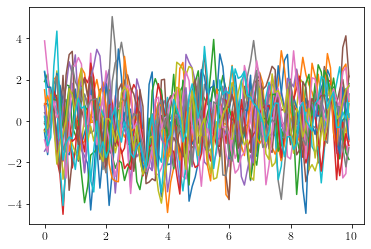

In [8]:
for i in range(20):
    w = np.random.randn(N,1)
    f = sqrtK@w + mu_post
    plt.plot(x,f)

Example of Maximum Likelihood Estimation

Optimization terminated successfully.
         Current function value: -262.706997
         Iterations: 11
         Function evaluations: 16
         Gradient evaluations: 16
Learned hyperparameters [a,d,v] =  [1.27509154 0.92080221 0.06171716]
RMSE Prediction: 0.0734584845128541
RMSE Noise: 0.24188002226683358


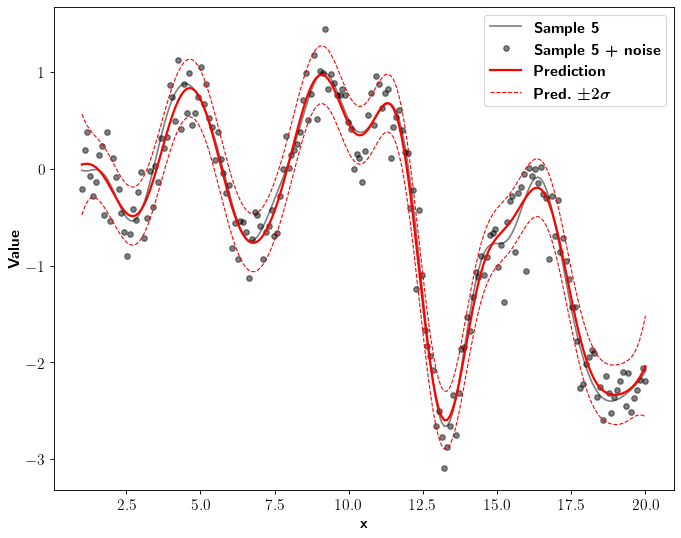

In [184]:
def testRun(y_sample = None, y_noise = None, ):
    '''
    One dimensional case, learning two hyperparameters from a sample of the GP prior with added noise.
    '''
    ## take sample if not provided
    if y_sample == None:
        n = 200
        xmin = 1
        xmax = 20
        x = np.linspace(xmin,xmax,n).reshape(-1,1)

        # define hyps
        a = 1
        d = 1

        Kx = Kexp([a,d],x,x)
        sqrtKx = np.real( la.sqrtm(Kx) )

        sig = 0.2
        y_sample = sqrtKx @ np.random.normal(0,1, (n,1))
        y_noise = y_sample + np.random.normal(0,sig, (n,1) )  

    # Hyperparameter training
    hyps = hypLearn_exp(x,y_noise)

    # Make predictions
    pred, std = GPpred(hyps,x,y_noise,x)
    print(f'RMSE Prediction: {calc_rmse(pred,y_sample)}\nRMSE Noise: {calc_rmse(y_noise,y_sample)}')
    
    plt.figure(figsize=(10, 8), dpi=80)
    plt.plot(x,y,'k',label = r'\textbf{Sample 5}', alpha = 0.5)
    plt.plot(x,y_noise,'ko',label = r'\textbf{Sample 5 + noise}', alpha = 0.5, markersize = 5)
    plt.plot(x,pred, color = 'red',label = r'\textbf{Prediction}', alpha = 1, linewidth = 2)
    plt.plot(x,pred + 2*std, color = 'red', linestyle = '--', linewidth = 1)
    plt.plot(x,pred - 2*std, color = 'red', linestyle = '--',linewidth = 1, label = r'\textbf{Pred.} \boldmath$\pm 2\sigma$')
    plt.xlabel(r'\textbf{x}')
    plt.ylabel(r'\textbf{Value}')
    plt.legend()
    plt.show()

    return pred

# run test code
y_pred = testRun(y_sample = y.reshape(-1,1),y_noise=y_noise.reshape(-1,1), )

In [200]:
def testRun2():
    '''
    Two dimensional case with data generated from trig function, estimating four hyperparameters
    '''
    n = 50
    xmin = -2*np.pi
    xmax = 2*np.pi
    ymin = -2*np.pi
    ymax = 2*np.pi
    
    X, Y = np.meshgrid(
        np.linspace(xmin, xmax, n),
        np.linspace(ymin, ymax, n)
    )
    XY = np.array([list(zip(x,y)) for x,y in zip(X,Y)]).reshape((n*n, 2))

    f = np.cos(XY[:,0]) + np.sin(XY[:,1])

    sig = 0.2
    y = f.reshape(-1,1) + np.random.normal(0,sig, (n*n,1) )

    # plot function surface
    # vmin, vmax = (-2.5,2.5)
    # norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    # levels = np.arange(vmin,vmax,0.1)
    # plt.figure(figsize=(8, 8), dpi=80)
    # plt.contourf(X, Y, y.reshape((n,n)),cmap='coolwarm',norm=norm, levels=levels)
    # plt.colorbar(label = r'\textbf{Function Value}')
    # plt.xlabel(r'\boldmath$x_1$')
    # plt.ylabel(r'\boldmath$x_2$')
    # plt.show()
  

    # Hyperparameter training
    hyps = hypLearn_exp(XY,y)

    # # Make predictions
    pred, std = GPpred(hyps,XY,y,XY)
    print(f'RMSE Prediction: {calc_rmse(pred,f.reshape(-1,1))}\nRMSE Noise: {calc_rmse(f.reshape(-1,1),y)}')

    # # plot prediction as surface
    # plt.figure(figsize=(8, 8), dpi=80)
    # plt.contourf(X, Y, pred.reshape((n,n)),cmap='coolwarm',norm=norm, levels=levels)
    # plt.colorbar(label = r'\textbf{Function Value}')
    # plt.xlabel(r'\boldmath$x_1$')
    # plt.ylabel(r'\boldmath$x_2$')
    # plt.show()

    # # plot slice
    # plt.figure(figsize=(10, 8), dpi=80)
    # plt.plot(XY.reshape((n,n,2))[0,:,0],f.reshape((n,n))[:,0],'k',label = r'\textbf{Data}', alpha = 0.5)
    # plt.plot(XY.reshape((n,n,2))[0,:,0],y.reshape((n,n))[:,0],'ko',label = r'\textbf{Data + noise}', alpha = 0.5, markersize = 5)
    # plt.plot(XY.reshape((n,n,2))[0,:,0],pred.reshape((n,n))[:,0],color = 'red',label = r'\textbf{Prediction}', linewidth = 2)
    # plt.plot(XY.reshape((n,n,2))[0,:,0],pred.reshape((n,n))[:,0]+ 2*std.reshape((n,n))[:,0], color = 'red', linestyle = '--', label = r'\boldmath$\pm 2 \sigma$',linewidth = 1)
    # plt.plot(XY.reshape((n,n,2))[0,:,0],pred.reshape((n,n))[:,0] - 2*std.reshape((n,n))[:,0], color = 'red', linestyle = '--',linewidth = 1)
    # plt.xlabel(r'\boldmath$x_1$')
    # plt.ylabel(r'\textbf{Value}')
    # plt.title(r'\boldmath$x_2 = 0$')
    # plt.legend()
    # plt.show()
    return #hyps
# run test code
testRun2()